# Building Personalized Avatar  Using Generative AI using Amazon SageMaker

Generative AI has become a popular tool for enhancing and accelerating the creative process across various industries, including entertainment, advertising, and art. It enables more personalized experiences for audiences and improves the overall quality of the final products. 

In this notebook, we will demonstrate how you can use generative AI models like Stable Diffusion (SD) to build a personalized avatar generator on Amazon SageMaker and save inference cost with Multi Model Endpoints at the same time. 

This notebook is tested on `PyTorch 2.0.0 Python 3.10 GPU Optimized` kernel on SageMaker Studio. An GPU instance such as `ml.g4dn.xlarge` is recommended.

## Set up the environment
Installs the dependencies required to package the model and test the fine-tuned model.

In [145]:
!pip install diffusers --quiet
!pip install peft --quiet
!pip install conda-pack --quiet
!pip install gradio --quiet

In [107]:
import sagemaker
from sagemaker.utils import name_from_base
from sagemaker.model import Model
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
import boto3
from pathlib import Path
import time
from io import BytesIO
import os
import tarfile
import base64
from PIL import Image

In [108]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
s3_prefix = (
    "stable-diffusion-dreambooth/code"  # folder within bucket where code artifact will go
)
mme_prefix = (
    "stable-diffusion-dreambooth/models"  # folder within bucket where mme models will be hosted
)
region = sess._region_name
account_id = sess.account_id()

## Setup Deep Java Library (DJL) Container

We will be using SageMaker Async inference and SageMaker managed Deep Java Library (DJL) container to run the fine tuning job. 

Even though Async Endpoint is designed for large payload (up to 1GB), long running process (up to one hour), and near real-time inference. We can take advantages of it’s built-in queue and notification for real-time training requests. As long as our training workload stays within the payload the processing time limits. Eliminate the need to self manage using additional components. 

We also chose DJLServing because the SageMaker managed inference container already has many of the training libraries we need, such as Transformers, Accelerate, and s5cmd.

Here is the DJL container we will use for the fine-tuning job.

In [109]:
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117


Push the parameter into `serving.properties` file

In [110]:
!sed -i 's@option.s3_bucket=.*@option.s3_bucket={bucket}@g' training_service/serving.properties
!sed -i 's@option.s3_prefix=.*@option.s3_prefix={s3_prefix}@g' training_service/serving.properties
!sed -i 's@option.mme_prefix=.*@option.mme_prefix={mme_prefix}@g' training_service/serving.properties

In [111]:
!pygmentize training_service/serving.properties | cat -n

     1	engine=Python
     2	option.model_loading_timeout=3600
     3	option.predict_timeout=3600
     4	minWorkers=2
     5	maxWorkers=2
     6	option.s3_bucket=sagemaker-us-west-2-376678947624
     7	option.s3_prefix=stable-diffusion-dreambooth/code
     8	option.mme_prefix=stable-diffusion-dreambooth/models


Package the model for DJLServe on SageMaker

In [112]:
!tar czvf sd_tuning.tar.gz training_service/

training_service/
training_service/utils.py
training_service/model.py
training_service/sd_lora/
training_service/sd_lora/config.pbtxt
training_service/sd_lora/1/
training_service/sd_lora/1/model.py
training_service/trainer.py
training_service/requirements.txt
training_service/train_dreambooth.py
training_service/serving.properties


In [113]:
sd_s3_code_artifact = sess.upload_data("sd_tuning.tar.gz", bucket, s3_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {sd_s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-376678947624/stable-diffusion-dreambooth/code/sd_tuning.tar.gz


## Create a SageMaker Asynchronous Endpoint

Create a function to package the container information, model files, and the IAM role into a single SageMaker model. Then deploy that model.

In [114]:
def deploy_model(image_uri, model_data, role, endpoint_name, instance_type, env, sagemaker_session, async_inference_config):
    
    """Helper function to create the SageMaker Endpoint resources and return a predictor"""
    
    model = Model(
            image_uri=image_uri, 
              model_data=model_data, 
              role=role,
              env=env
             )
    
    model.deploy(
        initial_instance_count=1,
        instance_type=instance_type,
        endpoint_name=endpoint_name,
        async_inference_config=async_inference_config
        )
    
    predictor = sagemaker.Predictor(
        endpoint_name=endpoint_name, 
        sagemaker_session=sagemaker_session
    )
    
    return predictor

Create an endpoint configuration that defines how our Async Inference will be served.

In [115]:
# create async endpoint configuration
async_config = AsyncInferenceConfig(
    output_path=f"s3://{bucket}/{s3_prefix}/async_inference/output" , # Where our results will be stored
    max_concurrent_invocations_per_instance=2,
    # notification_config={
            #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
    # }, #  Notification configuration
)

In [116]:
sd_endpoint_name = sagemaker.utils.name_from_base("sd-tuning")
sd_tuning = deploy_model(image_uri=inference_image_uri,
                            model_data=sd_s3_code_artifact,
                            role=role,
                            endpoint_name=sd_endpoint_name, 
                            instance_type="ml.g5.xlarge", 
                            sagemaker_session=sess,
                            env={"PREDICT_TIMEOUT": "3600", "MODEL_LOADING_TIMEOUT": "3600"},
                            async_inference_config=async_config)

----------!

Invoke the model to trigger the fine tuning job

In [117]:
sm_runtime = boto3.client("sagemaker-runtime")

This solution expects the training images samples to be a `tar.gz` file format. The image samples can be in `.jpg` or `.png` format. You can create the below code to create the tar archive file. It is recommended to create the tar file in SageMaker studio system/image terminal or any linux terminal. Creating the tar archieve on MACOS may create additional hidden files, that may cause the job to fail.

`tar -cvf jw.tar.gz jw1.jpg jw2.jpg jw3.jpg jw4.jpg jw5.jpg jw6.jpg jw7.jpg jw8.jpg jw9.jpg jw10.jpg`

The following code uploads the `tar.gz` file to S3.

In [118]:
input_s3_loc = sess.upload_data("data/jw.tar.gz", bucket, s3_prefix)

In [119]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=sd_tuning.endpoint_name, 
    CustomAttributes="jingswu",
    InputLocation=input_s3_loc)

**WAIT FOR FINE-TUNING TO COMPLETE** 

This may take up to 25 mins to complete

In [120]:
# write a function that checks if a full s3 path to a file exist
import boto3

def check_s3_file_exists(s3_path):
    # Split the S3 path into its components
    s3_components = s3_path.replace("s3://", "").split("/")
    bucket_name = s3_components[0]
    file_key = "/".join(s3_components[1:])
    
    # Create an S3 client
    s3 = boto3.client("s3")
    
    # Check if the object exists
    try:
        s3.head_object(Bucket=bucket_name, Key=file_key)
        return True
    except:
        return False

status = "Training"
print("Status: " + status)
s3_path = response["OutputLocation"]

while status == "Training":
    time.sleep(60)
    if check_s3_file_exists(s3_path):
        status = "Complete"
        
    print("Status: " + status)

Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Complete


## Test Fine-tuned Model locally

**download the training output file**

In [121]:
output_file = "output.json"
!aws s3 cp {response["OutputLocation"]} {output_file}

download: s3://sagemaker-us-west-2-376678947624/stable-diffusion-dreambooth/code/async_inference/output/07c68c85-2c09-4cf1-8187-e83beaee1a38.out to ./output.json


**Load the weights file from the output location**

In [122]:
import json

# write a function that import and then load a json file int a dictionary
def load_json_file(file_name):
    with open(file_name) as f:
        return json.load(f)

    
results = load_json_file(output_file)

output_filename = "output.tar.gz"

if results['status'] == "Training Completed!":
    # awscli to download a s3 file to a praticular filename
    !aws s3 cp {results['output_location']} {output_filename}
    
    target_model = results['output_location'].split("/")[-1]
    
    print(f"Target model: {target_model}")

download: s3://sagemaker-us-west-2-376678947624/stable-diffusion-dreambooth/models/9cfc48.tar.gz to ./output.tar.gz
Target model: 9cfc48.tar.gz


Check and verify LoRA weights is coorectly packed in the triton model folder for MME

```
sd_lora
|--config.pbtxt
|--1
   |--model.py
   |--output
      |--text_encoder/
      |--unet/
      |--train.sh
```

In [123]:
!tar -xvf {output_filename}

sd_lora/
sd_lora/1/
sd_lora/1/model.py
sd_lora/1/output/
sd_lora/1/output/text_encoder/
sd_lora/1/output/text_encoder/adapter_config.json
sd_lora/1/output/text_encoder/adapter_model.bin
sd_lora/1/output/train.sh
sd_lora/1/output/unet/
sd_lora/1/output/unet/adapter_config.json
sd_lora/1/output/unet/adapter_model.bin
sd_lora/config.pbtxt


**Load the stable diffusion model and apply the weights**

In [124]:
import diffusers
import torch 
from peft import PeftModel
import os

device="cuda"

weights_dir = "sd_lora/1/output"
unet_sub_dir = f"{weights_dir}/unet"
text_encoder_sub_dir =  f"{weights_dir}/text_encoder"


pipe = diffusers.StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                                             cache_dir='hf_cache',
                                                             torch_dtype=torch.float16,
                                                             revision="fp16")

# save the base model, we will need to use this for inference.
sd_dir = 'stable_diff'
pipe.save_pretrained(sd_dir)

# Load the LoRA weights
pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir)


if os.path.exists(text_encoder_sub_dir):
    pipe.text_encoder = PeftModel.from_pretrained(pipe.text_encoder, text_encoder_sub_dir)

pipe.unet.half()
pipe.text_encoder.half()

pipe.to(device)

text_encoder/model.safetensors not found
Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]















Fetching 12 files:  17%|█▋        | 2/12 [00:00<00:02,  4.49it/s]

































































Fetching 12 files: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.17.1",
  "feature_extractor": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "peft",
    "PeftModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "peft",
    "PeftModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

**Test with some sample prompts. ** Recommend to start with just `<<TOK>>`, this is the identifier used to fine tune the model.
SD should identify your facial features with this identifier, and provide an image the resembles you. If not, you may need to
provide additional image (better quality image). Or adjust the fine tuning parameters.

100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


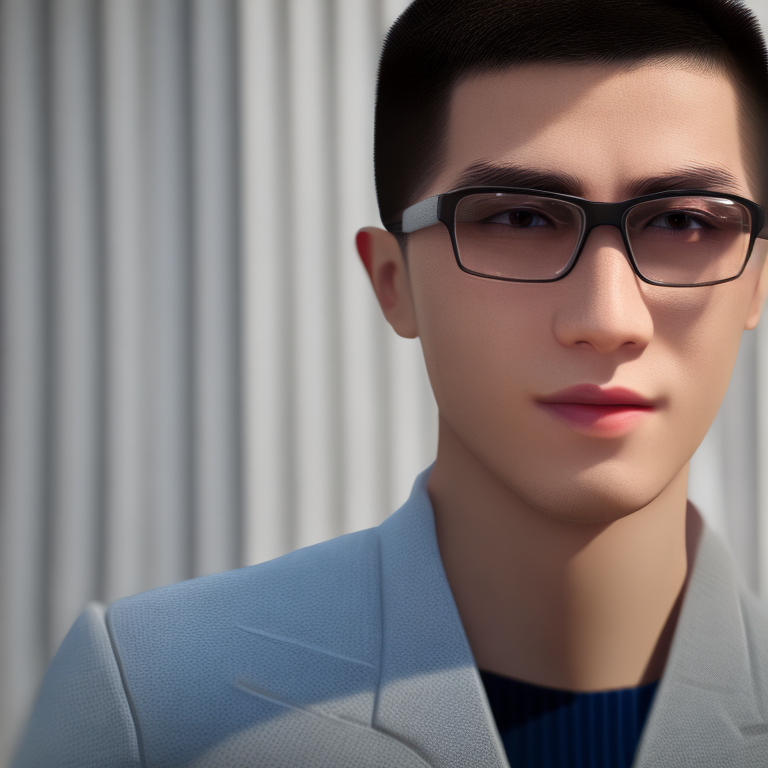

In [125]:
# prompt = "<<TOK>>"
prompt = """<<TOK>> epic portrait, young and handsome, with glasses, zoomed out, blurred background cityscape, bokeh, perfect symmetry, by artgem, artstation ,concept art,cinematic lighting, highly detailed, 
octane, concept art, sharp focus, rockstar games,
post processing, picture of the day, ambient lighting, epic composition"""
negative_prompt = """
beard, goatee, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands
"""
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

## Setup Multi-Model Endpoint

To effeciently reuse the underlying inferastructure, we are going to host fine-tuned models behind a single endpoint using SageMaker MMEs. We want to only load the LoRA wieghts (68 MB) instead of loading an entire SD model pipeline (~5GB). To accomplish this, we are going to pre-load the base SD model into the container like the diagram below:

<img src="statics/mme_diagram.png">

This design should improve cold start model latency, and eliminate potential timeout when an new model is invoked for the first time.

### Packaging a conda environment, extending Sagemaker Triton container <a name="condaenv"></a>

When using the Triton Python backend (which our Stable Diffusion model will run on), you can include your own environment and dependencies. The recommended way to do this is to use [conda pack](https://conda.github.io/conda-pack/) to generate a conda environment archive in `tar.gz` format, and point to it in the `config.pbtxt` file of the models that should use it, adding the snippet: 

```
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "path_to_your_env.tar.gz"}
}

```
You can use a different environment per model, or the same for all models (read more on this [here](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments)). Since the all of the models that we'll be deploying have the same set of environment requirements, we will create a single conda environment and will use a Python backend to copy that environment into a location where it can be accessed by all models.

> ⚠ **Warning**: The approach for a creating a shared conda environment highlighted here is limited to a single instance deployment only. In the event of auto-scaling, there is no guarantee that the new instance will have the conda environment configured. Since the conda environment for hosting Stable Diffusion models is quite large  the recommended approach for production deployments is to create shared environment by extending the Triton Inference Image.  

Let's start by creating the conda environment with the necessary dependencies; running these cells will output a `sd_env.tar.gz` file.

In [126]:
%%writefile environment.yml
name: mme_env
dependencies:
  - python=3.8
  - pip
  - pip:
      - numpy
      - torch --extra-index-url https://download.pytorch.org/whl/cu118
      - accelerate
      - transformers
      - diffusers
      - xformers
      - peft
      - conda-pack

Writing environment.yml


ow we can create the environment using the above environment yaml spec

It could take up to 5 min to create the conda environment. The packaged conda environment will be stored in `models/model_setup/` directory.

In [127]:
!conda env create -f environment.yml

Retrieving notices: ...working... done

CondaValueError: prefix already exists: /opt/.cs/conda/envs/mme_env



In [128]:
!conda pack -n mme_env -o models/model_setup/sd_env.tar.gz

Packing environment at '/opt/.cs/conda/envs/mme_env' to 'models/model_setup/sd_env.tar.gz'
[########################################] | 100% Completed |  3min 53.5s


### Package the stable diffusion base model
Store this into `models/model_setup/` directory

In [129]:
sd_tar = f"models/model_setup/{sd_dir}.tar.gz"

s3_client = boto3.client("s3")

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
    print(f"SD base model created here: {output_filename}")

make_tarfile(sd_tar, sd_dir)

SD base model created here: models/model_setup/stable_diff.tar.gz


Upload the utility model to S3 bucket

In [161]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [131]:
model_repo = "models"

model_name = "model_setup"
tar_name = f"{model_name}.tar.gz"
!tar -C $model_repo -czvf $tar_name $model_name
sess.upload_data(path=tar_name, bucket=bucket, key_prefix=mme_prefix)
!rm $tar_name

model_setup/
model_setup/config.pbtxt
model_setup/1/
model_setup/1/model.py
model_setup/sd_env.tar.gz
model_setup/stable_diff.tar.gz


### Deploy endpoint <a name="deploy"></a>

Now, we get the correct URI for the SageMaker Triton container image. Check out all the available Deep Learning Container images that AWS maintains [here](https://github.com/aws/deep-learning-containers/blob/master/available_images.md). 

In [132]:
# account mapping for SageMaker Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}


region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.12-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)

We are now ready to configure and deploy the multi-model endpoint

In [133]:
sm_client = boto3.client(service_name="sagemaker")

model_data_url = f"s3://{bucket}/{mme_prefix}/"

container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}

In [134]:
sm_model_name = name_from_base(f"{mme_prefix.split('/')[0]}-models")

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-west-2:376678947624:model/stable-diffusion-dreambooth-models-2023-07-06-01-46-07-109


Create a SageMaker endpoint configuration.

In [135]:
endpoint_config_name = name_from_base(f"{mme_prefix.split('/')[0]}-epc")

instance_type = 'ml.g5.xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint-config/stable-diffusion-dreambooth-epc-2023-07-06-01-46-07-807


Create the endpoint, and wait for it to transition to InService state.

In [136]:
endpoint_name = name_from_base(f"{mme_prefix.split('/')[0]}-ep")

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint/stable-diffusion-dreambooth-ep-2023-07-06-01-46-08-223
Status: InService


### Invoke MME Models
Prior to invoking any of the Stable Diffusion Models, we first invoke the `model_setup` which will copy the conda environment and stable diffusion base model into a directory that can be shared with all the other models. Refer to the [model.py](./models/model_setup/1/model.py) file in the `models/model_setup/1` directory for more details on the implementation.

In [137]:
# invoke the setup_conda model to create the shared conda environment
inputs = dict(input_args = "hello")


payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="model_setup.tar.gz",
)

output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
output

[{'name': 'output_message',
  'datatype': 'BYTES',
  'shape': [],
  'data': ['Model env setup successful.']}]

In [138]:
# helper functions to encode and decode images
def encode_image(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    img_str = base64.b64encode(buffer.getvalue())

    return img_str


def decode_image(img):
    buff = BytesIO(base64.b64decode(img.encode("utf8")))
    image = Image.open(buff)
    return image

### Invoke the LoRA fine tuned model

In [139]:
import random

prompt = """<<TOK>> epic portrait, zoomed out, blurred background cityscape, bokeh, perfect symmetry, by artgem, artstation ,concept art,cinematic lighting, highly detailed, 
octane, concept art, sharp focus, rockstar games,
post processing, picture of the day, ambient lighting, epic composition"""
negative_prompt = """
beard, goatee, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands
"""

seed = random.randint(1, 1000000000)
gen_args = json.dumps(dict(num_inference_steps=50, guidance_scale=7, seed=seed))

inputs = dict(prompt = prompt,
              negative_prompt = negative_prompt,
              gen_args = gen_args)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

CPU times: user 10 ms, sys: 4.24 ms, total: 14.3 ms
Wall time: 48.4 s


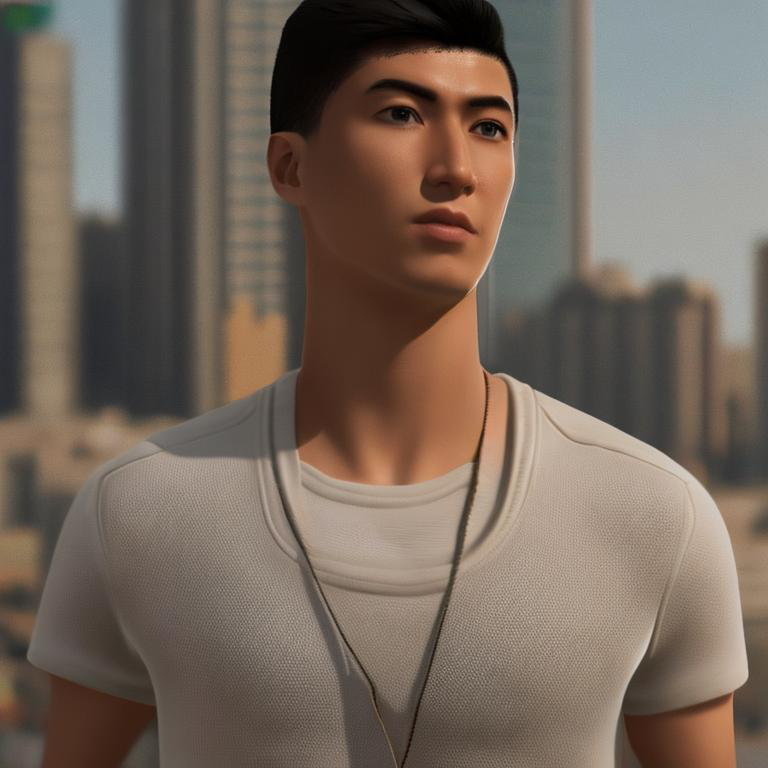

In [140]:
%%time
response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel=target_model,
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
original_image = decode_image(output[0]["data"][0])
original_image

## Create Simple Demo Using Gradio

Gradio is an open-source Python library that allows developers to easily create and share custom web-based interfaces for their machine learning models, without requiring any web development skills. 

After you have installed Gradio, run the code below. The interative UI will render directly in the output cell. You can interact with your models and generate avatars. Have fun :)

List available Stable Diffusion models behind the MME endpoint

In [151]:
def list_models(bucket_name, prefix):

    s3 = boto3.client("s3")
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    models = []
    for obj in response["Contents"]:
        model_name = obj["Key"].split("/")[-1]
        if model_name != "model_setup.tar.gz":
            models.append(model_name)

    return models

target_models = list_models(bucket, mme_prefix)
print(target_models)

['19e119.tar.gz', '5bfad3.tar.gz', '9cfc48.tar.gz']


front portrait, with glasses, zoomed out,  young and handsome,  perfectly centered, anime, cute-fine-face, illustration, realistic shaded perfect face,  fine details, image premiere,  4k resolution, a masterpiece

In [160]:
import gradio as gr
import numpy

# list available MME models from a S3 location
def refresh_model_list(s3):
    model_list = []
    for i in range(3):
        num = random.randint(0, 10)
        model_list.append(f"model-{num}.tar.gz")
    models = gr.Dropdown.update(choices=model_list)
    return models

with gr.Blocks() as demo:
    gr.Markdown("# Personalized Avatar Generator")
    with gr.Row():
        with gr.Column(scale=1):

            models = gr.Dropdown(choices=target_models, type="value",
                                 info="Choose a model", show_label=False)

            prompt = gr.Textbox(show_label=False,
                                info="Prompt:",
                                placeholder="Enter a prompt for your avatar")
            nprompt = gr.Textbox(show_label=False,
                                 info="Negative prompt:",
                                 placeholder="""beard, goatee, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands
""")

            create = gr.Button(value="Create")
        with gr.Column(scale=1):
            output_img = gr.Image(label="Output Image", type="pil", height=400)


    def generate_avatar(model_name, p, np, inf_steps=50, scale=10):
        
        s = random.randint(1, 1000000000)
        
        gen_args = json.dumps(dict(num_inference_steps=inf_steps, guidance_scale=scale, seed=s))

        inputs = dict(prompt = f"<<TOK>>, {p}",
                      negative_prompt = np,
                      gen_args = gen_args)

        payload = {
            "inputs":
                [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
        }
        
        response = sm_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/octet-stream",
            Body=json.dumps(payload),
            TargetModel=target_model,
        )
        output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
        output_image = decode_image(output[0]["data"][0])
        
        return output_image

    create.click(generate_avatar, [models, prompt, nprompt], output_img)

demo.launch()

Sagemaker notebooks may require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on local URL:  http://127.0.0.1:7870
Running on public URL: https://15adeb7d23da4c9bd4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Clean up <a name="query"></a>

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint(EndpointName=sd_endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=sm_model_name)